# RSA Conference 2022 - Lab1-T01 - Tutorial 1 (Hands on)

## Part 1 - White-Box Evasion Attack

In [ ]:
# Import PyTorch (torch) to create and train the classification model that will be attacked
import torch

# Import Numpy (numpy) to handle input and label data and analyze attack success
import numpy as np

# Import Matplotlib (matplotlib) to visualise the data
from matplotlib import pyplot as plt

# Import "weak" white-box attack FGSM from ART
from art.attacks.evasion import FastGradientMethod

# Import "strong" white-box attack PGD from ART
from art.attacks.evasion import ProjectedGradientDescent

# Import black-box attack HopSkipJump from ART
from art.attacks.evasion import HopSkipJump

# Import classification estimator for PyTorch from ART to abstract attacked model and connect it with attack
from art.estimators.classification import PyTorchClassifier

# Import ART's BlackBoxClassifier to abstract classifier which only provide query access
from art.estimators.classification import BlackBoxClassifier

# Import preprocessor for spatial smoothing as defensive approach (not secure, but good for demonstration)
from art.defences.preprocessor import SpatialSmoothingPyTorch

# Import utility methods to load MNIST data
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

### Part 1 - Step 1: Define the neural network model, return logits instead of activation in forward method

In [ ]:
# Define architecture of the attacked model. Here we use a convolutional neural network with 2 Conv
# and 2 Dense layers.

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = torch.nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = torch.nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv_1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv_2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = torch.nn.functional.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [ ]:
# Define function to visualise input images

def plot_image(x, y, y_pred=None):
    for i, (x_i, y_i) in enumerate(zip(x, y)):
        x_i = x_i[0, :, :]
        plt.matshow(x_i)
        plt.show()
        print(f"The true label is: {np.argmax(y_i, axis=0)}")
        if y_pred is not None:
            print(f"The predicted label is: {np.argmax(y_pred[i], axis=0)}")

### Part 1 - Step 2: Load and inpsect the MNIST dataset

In [ ]:
# Load data and labels of MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
# Change format from NHWC to NCHW for PyTorch

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [ ]:
plot_image(x_train[0:2], y_train[0:2])

### Part 1 - Step 3: Create the model, loss, optimizer and train the model on classifiying MNIST

In [ ]:
# Creat model that will be attacked

model = Net()

In [ ]:
# Define loss and optimizer to train model, this is not necessary if a model is loaded from a saved checkpoint.

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train the model and evaluate on test data
# Modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

nb_epochs = 3
batch_size = 64

x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
dataset_train = torch.utils.data.TensorDataset(x_train_tensor,y_train_tensor)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)

x_test_tensor = torch.Tensor(x_test)
y_test_tensor = torch.Tensor(y_test)
dataset_test = torch.utils.data.TensorDataset(x_test_tensor,y_test_tensor)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=2)

for epoch in range(nb_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    
    for i, data in enumerate(loader_train, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

correct = 0
total = 0

with torch.no_grad():
    for data in loader_test:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_index = torch.max(labels.data, 1)
        total += labels.size(0)
        correct += (predicted == labels_index).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
"""
Now our work starts!
""";

### Part 1 - Step 4: Create the ART classifier

In [ ]:
"""
First, we need to abstract the model to be attack with the correspondin estimator of ART's Estimator API
and make it compatible with ART's attacks.

Becasue our model is a classifier and created in PyTorch we will use ART's PyTorchClassifier.

At the minimum PyTorchClassifier needs to know from the user:
    - model: the model to attack
    - loss: the loss definition to attack, for classification e.g. cross-entropy
    - clip_values: a tuple of minimum and maximum value of the input to make sure the adversarial
                   examples generated are in the valid value range
    - input_shape: the shape of one input sample
    - nb_classes: the number of classes in the dataset

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    clip_values=(min_pixel_value, max_pixel_value),
    input_shape=(1, 28, 28),
    nb_classes=10,
)
""";

In [ ]:
# Create ART classifier

classifier = _

### Part 1 - Step 5: Evaluate the ART classifier on benign test examples

In [ ]:
# Check the created classifier with predictions on the benign test samples to ensure everything is
# set up correctly.

predictions = classifier.predict(x_test)

# Evaluate predictions

accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on benign test examples: {accuracy_benign * 100:.2f} %")

### Part 1 - Step 6: Generate adversarial test examples and evaluate attack success

In [ ]:
"""
Next, we will create a white-box evasion attack which adds small perturbations to create adversarial
exmaples that result in mis-classificaiton.

We will start with the Fast Gradient Sign Method (FGSM) which back-propagates the classification loss through the
model to the inputs to uses the gradietns to find the direction of maximal increase in classification loss.

FGSM does only one of these loss gradient steps.

Let's create an instance of the attack using FastGradientMethod requiring from the user
    - estimator: the ART estimator (classifier) to attack
    - eps: the maximum perturbation to apply, or how much the attack can pertrub the input to find an
           adversarial example
    - norm: the norm use to define eps

attack = FastGradientMethod(estimator=classifier, norm=np.inf, eps=0.2)

All evasion attacks of ART create adversarial examples by running the attack's method `generate` which takes
takes as input:
    - x: the benign samples to turn into adversarial examples
    - y: the true labels of the samples

x_test_adv = attack.generate(x=x_test, y=y_test)
""";

- Fast Gradient Sign Method by goodfellow et al. (2014)

- Paper link: https://arxiv.org/abs/1412.6572

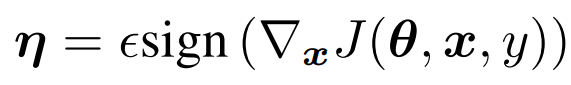

In [ ]:
# Create an instance of an FGSM attack

attack_fgsm = _

In [ ]:
# Generate adversarial examples

x_test_adv = _

In [ ]:
# Evaluate predictions

predictions = classifier.predict(x_test_adv)
accuracy_fgsm = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial test examples: {accuracy_fgsm * 100:.2f}%")

In [ ]:
plot_image(x_test_adv[0:3], y_test[0:3], predictions[0:3])

In [ ]:
"""
Optional: Repeat the last 3 cells with different values for attack budget `eps`. Try to show that larger 
values for `eps` make the attack stronger but easier to recognise.
""";

## Part 2 - Adaptive White-Box Evasion Attack

### Step 1 - Create a differentiable preprocessor "defense"

In [ ]:
"""
Create an instance of ART spatial smoothing preprocessor. We need to priovde the following ifnromation:

    - window_size: the size of the smooting window in pixels
    - clip_values: a tuple of minimum and maximum value of the input to make sure the adversarial
                   examples generated are in the valid value range
    - channels_first: boolean defining if channels first images (here False because NCHW format of images)
    

preprocessor = SpatialSmoothingPyTorch(window_size=3, clip_values=(0, 1), channels_first=True)
""";

In [ ]:
# Create an instance of the preprocessor

preprocessor = _

In [ ]:
### Step 2 - Create a new ART classifier providing the preprocessor

In [ ]:
"""
Create a new ART classifier that includes the spatial smoothing preprocessor as a preprocessing defense. This
will allow us to backpropagate the gradients thorugh the defense and create adversarial examples that are
robust against the preprocessing step.

Provide the instance of the preprocessor to the argument `preprocessing_defences` of PyTorchClassifier:

classifier_defended = PyTorchClassifier(
    model=model,
    loss=criterion,
    clip_values=(min_pixel_value, max_pixel_value),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing_defences=preprocessor
)
""";

In [ ]:
classifier_defended = _

### Step 3 - Check accuracy of "defended" classifier on benign test data

In [ ]:
# Check the created classifier with predictions on the benign test samples to ensure everything is
# set up correctly.

predictions = classifier_defended.predict(x_test)

# Evaluate predictions

accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on benign test examples: {accuracy_benign * 100:.2f} %")

### Step 4 - Repeat "weak" FGSM attack of Part 1

In [ ]:
# Create an instance of an FGSM attack

attack_fgsm = FastGradientMethod(estimator=classifier_defended, norm=np.inf, eps=0.2)

# Generate adversarial examples

x_test_adv = attack_fgsm.generate(x=x_test, y=y_test)

# Evaluate predictions

predictions = classifier_defended.predict(x_test_adv)
accuracy_fgsm = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial test examples: {accuracy_fgsm * 100:.2f}%")

### Step 5 - Create a "stronger" attack using Projected Gradient Descent (PGD)

In [ ]:
"""
Projected Gradient Descent (PGD) runs a sequence of signed gradient steps and is therefore able to further
increase the classification loss.

Let's create and instance of a PGD attack:
    - estimator: the ART estimator (classifier) to attack
    - norm: the norm use to define eps
    - eps: the maximum perturbation to apply, or how much the attack can pertrub the input to find an
           adversarial example
    - eps_step: the perturbation size applied in each iteration step
    - max_iter: the number of iterations or applications of signed gradient steps

attack_pgd = ProjectedGradientDescent(estimator=classifier_defended,
                                      norm=np.inf,
                                      eps=0.2,
                                      eps_step=0.01,
                                      max_iter=40,
                                      verbose=False)
""";

In [ ]:
# Create an instance of an PGD attack

attack_pgd = _

### Step 6 - Generate stronger adversarial examples using PGD

In [ ]:
# Generate adversarial examples

x_test_adv = attack_pgd.generate(x=x_test, y=y_test)

# Evaluate predictions

predictions = classifier_defended.predict(x_test_adv)
accuracy_fgsm = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial test examples: {accuracy_fgsm * 100:.2f}%")

In [ ]:
plot_image(x_test_adv[0:3], y_test[0:3], predictions[0:3])

## Part 3 - Black-Box Evasion Attack

### Step 1 - Create a ART Black-Box Classifier

In [ ]:
# Define a function that queries the attacked classifier model
def predict_func(x):
    x_tensor = torch.Tensor(x)
    outputs = model(x_tensor)
    return outputs.data.numpy()

# Create an instance of BlackBoxClassifier
classifier_blackbox = BlackBoxClassifier(predict_func,
                                         input_shape=(1, 28, 28),
                                         nb_classes=10,
                                         clip_values=(0, 1))

# Evaluate predictions

predictions = classifier_blackbox.predict(x_test)
accuracy_fgsm = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial test examples: {accuracy_fgsm * 100:.2f}%")

### Step 2 - Create a black-box attack using HopSkipJump

In [ ]:
"""
A black-box evasion attack can create adversarial examples just by querying the attacked model. We will use
the HopSkipJump attack which follows the classifier's decision boundary to minimise the required adversarial
perturbation.

attack_hopskipjump = HopSkipJump(classifier=classifier_blackbox,
                                 batch_size=64,
                                 norm=np.inf,
                                 max_iter=50,
                                 max_eval=100,
                                 init_eval=100,
                                 init_size=100,
                                 verbose=False,)
""";

In [ ]:
# Create an instance of an HopSkipJump attack

attack_hopskipjump = _

### Step 3 - Generate adversarial examples with HopSkipJump black-box evasion attack

- HopSkipJump by Chen et al. (2019)

- Paper link: https://arxiv.org/abs/1904.02144

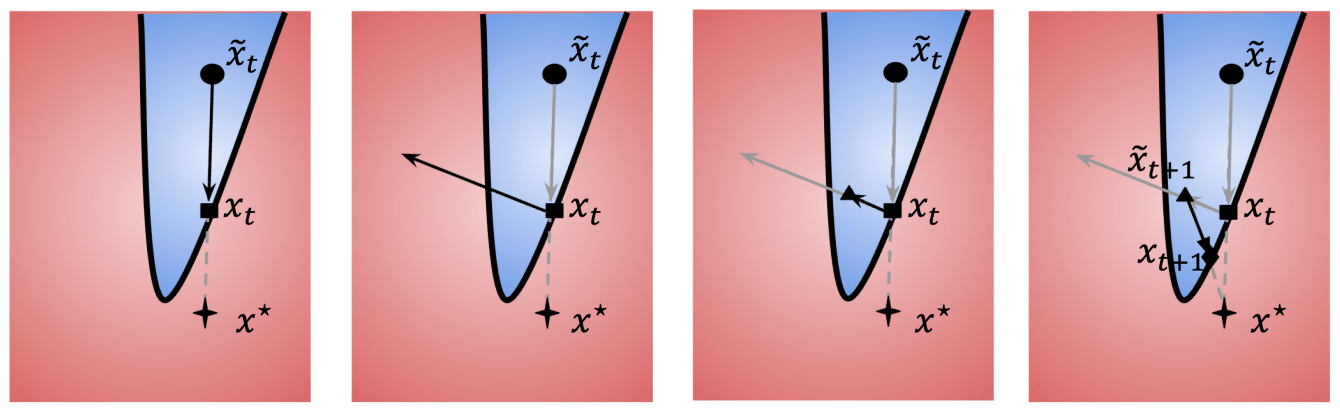

In [ ]:
# Generate adversarial examples

x_test_adv = attack_hopskipjump.generate(x=x_test[0:10], y=y_test[0:10])

# Evaluate predictions

predictions = classifier_blackbox.predict(x_test_adv)
accuracy_hsj = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on adversarial test examples: {accuracy_hsj * 100:.2f}%")

In [ ]:
plot_image(x_test_adv[0:3], y_test[0:3], predictions[0:3])